In [61]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
# Load Data
train = pd.read_csv('/content/drive/MyDrive/portfolio/Prudential Life Insurance Assessment Analysis/prudential-life-insurance-assessment/train.csv')
test = pd.read_csv('/content/drive/MyDrive/portfolio/Prudential Life Insurance Assessment Analysis/prudential-life-insurance-assessment/test.csv')
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (59381, 128)
Test shape: (19765, 127)


In [63]:
print(list(train.columns))
# Id
# Product_Info_1-7: normalized variables relating to the product applied for
# Ins_Age
# Ht, Wt, BMI
# Employment_Info_1-6
# InsuredInfo_1-7
# Insurance_History_1-9 x6
# Family_Hist_1-5
# Medical_History_1-41
# Medical_Keyword_1-48
# Response

['Id', 'Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_4', 'Employment_Info_5', 'Employment_Info_6', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_5', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5', 'Medical_History_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_10', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_15', 'M

In [64]:
print(train.head())

   Id  Product_Info_1 Product_Info_2  Product_Info_3  Product_Info_4  \
0   2               1             D3              10        0.076923   
1   5               1             A1              26        0.076923   
2   6               1             E1              26        0.076923   
3   7               1             D4              10        0.487179   
4   8               1             D2              26        0.230769   

   Product_Info_5  Product_Info_6  Product_Info_7   Ins_Age        Ht  ...  \
0               2               1               1  0.641791  0.581818  ...   
1               2               3               1  0.059701  0.600000  ...   
2               2               3               1  0.029851  0.745455  ...   
3               2               3               1  0.164179  0.672727  ...   
4               2               3               1  0.417910  0.654545  ...   

   Medical_Keyword_40  Medical_Keyword_41  Medical_Keyword_42  \
0                   0            

In [65]:
missing_percent = train.isnull().mean()
print(missing_percent)

Id                    0.0
Product_Info_1        0.0
Product_Info_2        0.0
Product_Info_3        0.0
Product_Info_4        0.0
                     ... 
Medical_Keyword_45    0.0
Medical_Keyword_46    0.0
Medical_Keyword_47    0.0
Medical_Keyword_48    0.0
Response              0.0
Length: 128, dtype: float64


In [66]:
# Drop columns with >50% missing
# train.isnull(), NaN -> True -> 1, False -> 0, mean()->avg 1s in each column
drop_columns = missing_percent[missing_percent > 0.5].index
train = train.drop(columns=drop_columns)
test = test.drop(columns=drop_columns)
print("Dropped columns:", drop_columns.tolist())

Dropped columns: ['Family_Hist_3', 'Family_Hist_5', 'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32']


In [67]:
# Impute NaNs
numerical_cols = train.select_dtypes(include=['float64', 'int64']).columns.drop(['Id', 'Response'])
categorical_cols = train.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

train[numerical_cols] = imputer_num.fit_transform(train[numerical_cols])
train[categorical_cols] = imputer_cat.fit_transform(train[categorical_cols])

test[numerical_cols] = imputer_num.transform(test[numerical_cols])
test[categorical_cols] = imputer_cat.transform(test[categorical_cols])
print("Missing values after imputation (train):", train.isnull().sum().sum())

Missing values after imputation (train): 0


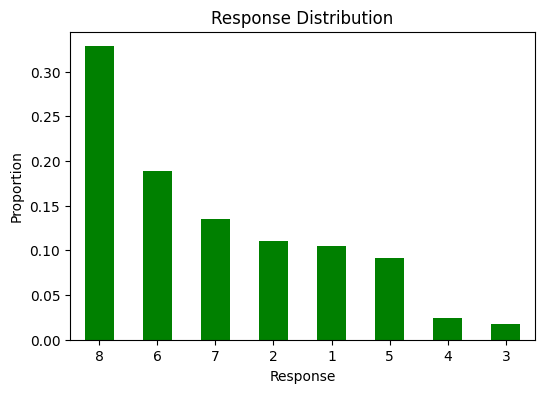

In [68]:
# Response Distribution --> imbalanced dataset
response_counts = train['Response'].value_counts(normalize=True) # normalize=True -> percentage
plt.figure(figsize=(6,4))
response_counts.plot(kind='bar', color='green')
plt.title("Response Distribution")
plt.xlabel("Response")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()

In [69]:
# Classify and standardize numerical columns

to_standardize = []
already_standardized = []
categorical_binary = []

for col in numerical_cols:
    min_val = train[col].min()
    max_val = train[col].max()
    unique_vals = train[col].nunique()
    range_val = max_val - min_val

    if unique_vals == 2 and min_val == 0 and max_val == 1:
        categorical_binary.append(col) #binary
    elif unique_vals <= 10 and max_val <= 10:
        categorical_binary.append(col) #categorical
    elif min_val >= 0 and 0.95 <= max_val <= 1.05 and range_val > 0.4 and unique_vals > 20:
        already_standardized.append(col) # already standardized
    else:
        to_standardize.append(col)
print("Numerical columns to_standardize:", to_standardize)

Numerical columns to_normalize: ['Product_Info_3', 'Employment_Info_2', 'InsuredInfo_3', 'Family_Hist_4', 'Medical_History_1', 'Medical_History_2']


In [70]:
# Standardize numerical columns
scaler = StandardScaler()
train[to_standardize] = scaler.fit_transform(train[to_standardize])
test[to_standardize] = scaler.transform(test[to_standardize])

In [71]:
# Feature Engineering
med_cols = [col for col in train.columns if 'Medical_Keyword_' in col]
ins_hist_cols = [col for col in train.columns if 'Insurance_History_' in col]
new_features_train = pd.DataFrame({
    'Medical_Keyword_Count': train[med_cols].sum(axis=1),
    'BMI_Age_Interaction': train['BMI'] * train['Ins_Age'],
    'Medical_Risk_Score': train[med_cols].mean(axis=1) + train['BMI'],
    'Insurance_History_Score': train[ins_hist_cols].mean(axis=1)
})
new_features_test = pd.DataFrame({
    'Medical_Keyword_Count': test[med_cols].sum(axis=1),
    'BMI_Age_Interaction': test['BMI'] * test['Ins_Age'],
    'Medical_Risk_Score': test[med_cols].mean(axis=1) + test['BMI'],
    'Insurance_History_Score': test[ins_hist_cols].mean(axis=1)
})
train = pd.concat([train, new_features_train], axis=1)
test = pd.concat([test, new_features_test], axis=1)
print("New features added:", new_features_train.columns.tolist())

New features added: ['Medical_Keyword_Count', 'BMI_Age_Interaction', 'Medical_Risk_Score', 'Insurance_History_Score']


In [72]:
# Standardize new features
new_features_to_standardize = ['Medical_Keyword_Count', 'BMI_Age_Interaction', 'Medical_Risk_Score', 'Insurance_History_Score']
scaler_new = StandardScaler()
train[new_features_to_standardize] = scaler_new.fit_transform(train[new_features_to_standardize])
test[new_features_to_standardize] = scaler_new.transform(test[new_features_to_standardize])
print("New features standardize:", new_features_to_standardize)

New features normalized: ['Medical_Keyword_Count', 'BMI_Age_Interaction', 'Medical_Risk_Score', 'Insurance_History_Score']


In [73]:
# Encode Product_Info_2
le = LabelEncoder()
train['Product_Info_2'] = le.fit_transform(train['Product_Info_2'])
test['Product_Info_2'] = le.transform(test['Product_Info_2'])
print("Product_Info_2 encoded. Unique values in train:", train['Product_Info_2'].unique())

Product_Info_2 encoded. Unique values in train: [16  0 18 17 15  7  1 14  6  5  2  4 13 10  9 12 11  3  8]


In [74]:
# Define X and y
X_log = train.drop(columns=['Id', 'Response'])  # For Logistic Regression
X_tree = train.drop(columns=['Id', 'Response'])  # For RF and XGBoost
y = train['Response'] - 1  # Adjust to 0-7 for XGBoost

In [96]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
balanced_acc_scores = []
roc_auc_scores = []
all_y_true = []
all_y_pred = []

for train_idx, val_idx in skf.split(X_log, y):
    X_train, X_val = X_log.iloc[train_idx], X_log.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    log_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict(X_val)
    all_y_true.extend(y_val)
    all_y_pred.extend(y_pred)
    balanced_acc_scores.append(balanced_accuracy_score(y_val, y_pred))
    y_prob = log_model.predict_proba(X_val)
    roc_auc_scores.append(roc_auc_score(y_val, y_prob, multi_class='ovr'))

print("Logistic Regression CV Results (5-fold StratifiedKFold):")
print(f"Average Balanced Accuracy: {np.mean(balanced_acc_scores):.3f}")
print(f"Average ROC-AUC (ovr): {np.mean(roc_auc_scores):.3f}")
print("Classification Report (aggregated across folds):")
print(classification_report(all_y_true, all_y_pred))

Logistic Regression CV Results (5-fold StratifiedKFold):
Average Balanced Accuracy: 0.286
Average ROC-AUC (ovr): 0.801
Classification Report (aggregated across folds):
              precision    recall  f1-score   support

           0       0.39      0.26      0.31      6207
           1       0.36      0.19      0.25      6552
           2       0.21      0.01      0.02      1013
           3       0.28      0.02      0.04      1428
           4       0.40      0.23      0.29      5432
           5       0.36      0.41      0.38     11233
           6       0.40      0.25      0.31      8027
           7       0.58      0.90      0.70     19489

    accuracy                           0.48     59381
   macro avg       0.37      0.29      0.29     59381
weighted avg       0.44      0.48      0.43     59381



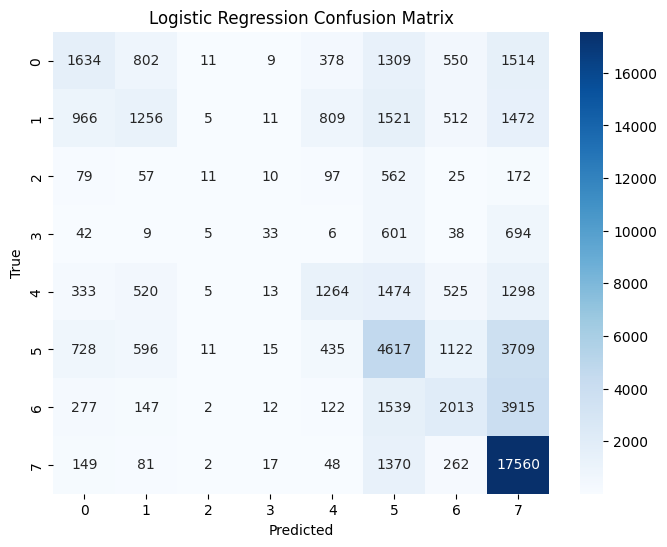

In [76]:
cm_log = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [77]:
# Random Forest CV
balanced_acc_scores_rf = []
roc_auc_scores_rf = []
all_y_true_rf = []
all_y_pred_rf = []

for train_idx, val_idx in skf.split(X_tree, y):
    X_train, X_val = X_tree.iloc[train_idx], X_tree.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    all_y_true_rf.extend(y_val)
    all_y_pred_rf.extend(y_pred)
    balanced_acc_scores_rf.append(balanced_accuracy_score(y_val, y_pred))
    y_prob = rf_model.predict_proba(X_val)
    roc_auc_scores_rf.append(roc_auc_score(y_val, y_prob, multi_class='ovr'))

print("Random Forest CV Results (5-fold StratifiedKFold):")
print(f"Average Balanced Accuracy: {np.mean(balanced_acc_scores_rf):.3f}")
print(f"Average ROC-AUC (ovr): {np.mean(roc_auc_scores_rf):.3f}")
print("Classification Report (aggregated across folds):")
print(classification_report(all_y_true_rf, all_y_pred_rf))

Random Forest CV Results (5-fold StratifiedKFold):
Average Balanced Accuracy: 0.318
Average ROC-AUC (ovr): 0.825
Classification Report (aggregated across folds):
              precision    recall  f1-score   support

           0       0.49      0.13      0.21      6207
           1       0.47      0.23      0.31      6552
           2       0.00      0.00      0.00      1013
           3       0.00      0.00      0.00      1428
           4       0.56      0.52      0.54      5432
           5       0.38      0.47      0.42     11233
           6       0.46      0.27      0.34      8027
           7       0.58      0.93      0.72     19489

    accuracy                           0.52     59381
   macro avg       0.37      0.32      0.32     59381
weighted avg       0.48      0.52      0.47     59381



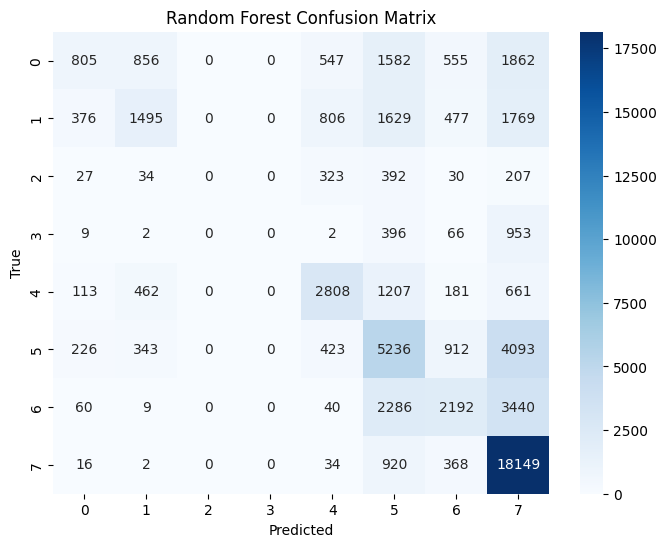

In [78]:
cm_rf = confusion_matrix(all_y_true_rf, all_y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [79]:
# XGBoost CV
balanced_acc_scores_xgb = []
roc_auc_scores_xgb = []
all_y_true_xgb = []
all_y_pred_xgb = []
for train_idx, val_idx in skf.split(X_tree, y):
    X_train, X_val = X_tree.iloc[train_idx], X_tree.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_val)
    all_y_true_xgb.extend(y_val)
    all_y_pred_xgb.extend(y_pred)
    balanced_acc_scores_xgb.append(balanced_accuracy_score(y_val, y_pred))
    y_prob = xgb_model.predict_proba(X_val)
    roc_auc_scores_xgb.append(roc_auc_score(y_val, y_prob, multi_class='ovr'))
print("XGBoost CV Results (5-fold StratifiedKFold):")
print(f"Average Balanced Accuracy: {np.mean(balanced_acc_scores_xgb):.3f}")
print(f"Average ROC-AUC (ovr): {np.mean(roc_auc_scores_xgb):.3f}")
print("Classification Report (aggregated across folds):")
print(classification_report(all_y_true_xgb, all_y_pred_xgb))

XGBoost CV Results (5-fold StratifiedKFold):
Average Balanced Accuracy: 0.381
Average ROC-AUC (ovr): 0.842
Classification Report (aggregated across folds):
              precision    recall  f1-score   support

           0       0.43      0.27      0.33      6207
           1       0.44      0.28      0.34      6552
           2       0.28      0.07      0.11      1013
           3       0.32      0.16      0.21      1428
           4       0.59      0.51      0.54      5432
           5       0.43      0.51      0.47     11233
           6       0.46      0.38      0.42      8027
           7       0.66      0.88      0.76     19489

    accuracy                           0.55     59381
   macro avg       0.45      0.38      0.40     59381
weighted avg       0.52      0.55      0.52     59381



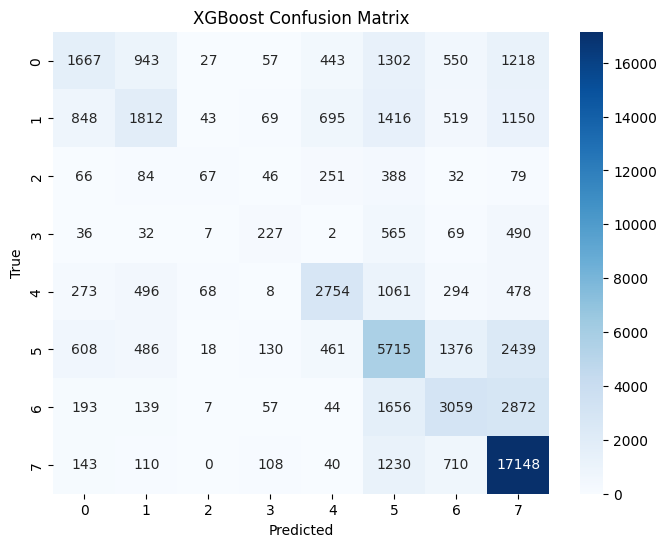

In [80]:
cm_xgb = confusion_matrix(all_y_true_xgb, all_y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [90]:
xgb_base = XGBClassifier(random_state=42, eval_metric='mlogloss', tree_method='hist')

# Define hyperparameter grid
param_grid = {
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}


# Perform Grid Search with 5-fold CV
grid_search = GridSearchCV(
    xgb_base, param_grid, cv=skf, scoring='roc_auc_ovr', n_jobs=-1
)

# Fit the model on the dataset
grid_search.fit(X_tree, y)

# Get the best model from GridSearch
xgb_model = grid_search.best_estimator_

# Print best parameters and score
print("\nBest XGBoost Params:", grid_search.best_params_)


Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}


In [91]:
balanced_acc_scores_xgb_best = []
roc_auc_scores_xgb_best = []
all_y_true_xgb_best = []
all_y_pred_xgb_best = []

for train_idx, val_idx in skf.split(X_tree, y):
    # Split training and validation folds
    X_train, X_val = X_tree.iloc[train_idx], X_tree.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train the best XGBoost model found by GridSearch
    xgb_model.fit(X_train, y_train)

    # Make predictions
    y_pred = xgb_model.predict(X_val)
    all_y_true_xgb_best.extend(y_val)
    all_y_pred_xgb_best.extend(y_pred)

    # Compute Balanced Accuracy
    balanced_acc_scores_xgb_best.append(balanced_accuracy_score(y_val, y_pred))

    # Compute ROC-AUC
    y_prob = xgb_model.predict_proba(X_val)
    roc_auc_scores_xgb_best.append(roc_auc_score(y_val, y_prob, multi_class='ovr'))

# Print final results
print(f"\nXGBoost CV Results_best (5-fold StratifiedKFold):")
print(f"Average Balanced Accuracy_best: {np.mean(balanced_acc_scores_xgb_best):.3f}")
print(f"Average ROC-AUC (ovr)_best: {np.mean(roc_auc_scores_xgb_best):.3f}")
print("\nClassification Report_best (aggregated across folds):")
print(classification_report(all_y_true_xgb_best, all_y_pred_xgb_best))


XGBoost CV Results_best (5-fold StratifiedKFold):
Average Balanced Accuracy_best: 0.380
Average ROC-AUC (ovr)_best: 0.847

Classification Report_best (aggregated across folds):
              precision    recall  f1-score   support

           0       0.46      0.26      0.33      6207
           1       0.46      0.27      0.34      6552
           2       0.33      0.07      0.11      1013
           3       0.32      0.14      0.20      1428
           4       0.59      0.52      0.55      5432
           5       0.43      0.52      0.47     11233
           6       0.47      0.38      0.42      8027
           7       0.66      0.89      0.76     19489

    accuracy                           0.55     59381
   macro avg       0.46      0.38      0.40     59381
weighted avg       0.53      0.55      0.52     59381



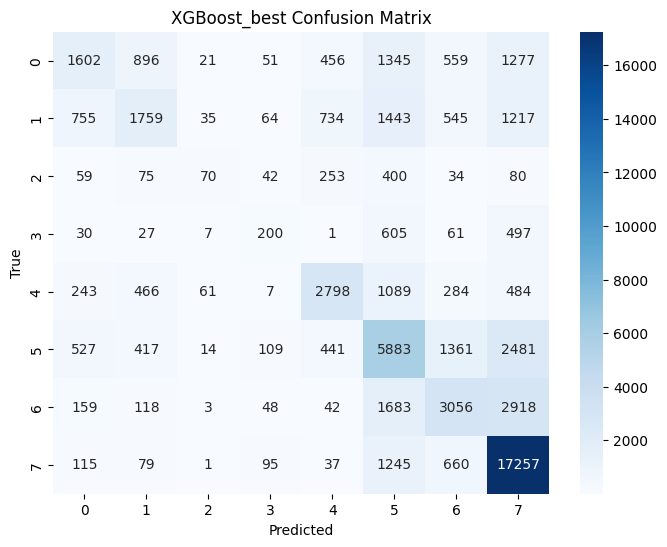

In [92]:
cm_xgb_best = confusion_matrix(all_y_true_xgb_best, all_y_pred_xgb_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb_best, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost_best Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Top 10 Feature Importances:
                Feature  Importance
38    Medical_History_4    0.075158
86   Medical_Keyword_15    0.058920
55   Medical_History_23    0.058742
74    Medical_Keyword_3    0.042902
122  Medical_Risk_Score    0.034993
10                  BMI    0.026796
3        Product_Info_4    0.022209
61   Medical_History_30    0.018564
70   Medical_History_40    0.018511
0        Product_Info_1    0.016101


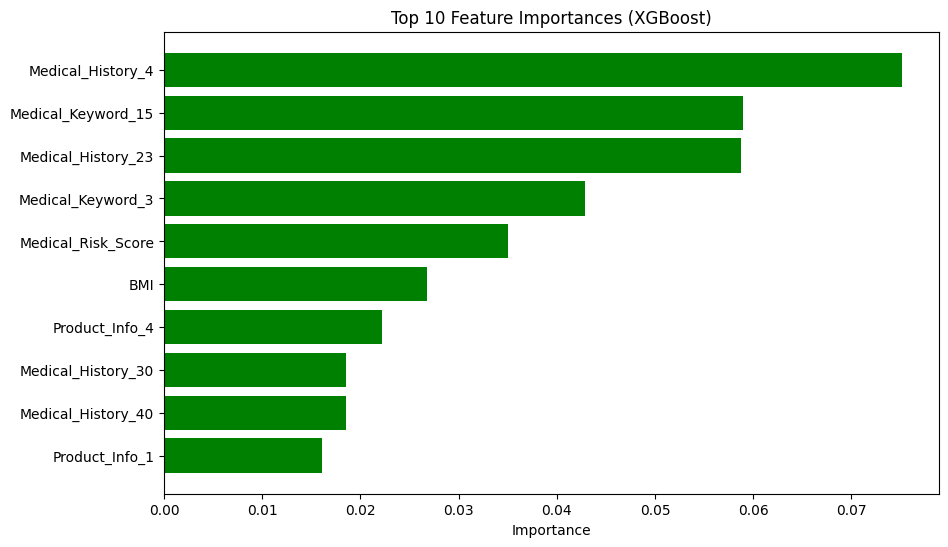

In [93]:
# Feature Importance
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_tree.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)
print("\nTop 10 Feature Importances:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='green')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.show()

In [94]:
# Submission Predictions
print("Test columns before submission:", test.columns.tolist())
print("Test['Product_Info_2'] unique before prediction:", test['Product_Info_2'].unique())

# test is already preprocessed (normalized and encoded) from earlier steps
X_test = test.drop(columns=['Id'])
y_test_pred = xgb_model.predict(X_test)  # xgb_model is grid_search.best_estimator_ from PAGE 10
submission = pd.DataFrame({'Id': test['Id'], 'Response': y_test_pred + 1})  # Back to 1-8
submission.to_csv('/content/drive/MyDrive/portfolio/Prudential Life Insurance Assessment Analysis/submission_2.csv', index=False)
print("\nSubmission file 'submission_2.csv' created.")

Test columns before submission: ['Id', 'Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_4', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 'Ins_Age', 'Ht', 'Wt', 'BMI', 'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_4', 'Employment_Info_5', 'Employment_Info_6', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_5', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_4', 'Medical_History_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_11', 'Medical_History_12', 'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Med

In [97]:
# Function to calculate financial impact based on your slide
def calculate_financial_impact(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    # High-risk misclassification (Classes 6-7 misclassified as 0-5)
    high_risk_misclassified = cm[6, :6].sum() + cm[7, :6].sum()
    misclassification_cost = high_risk_misclassified * 50000

    # Churn revenue loss (Your Slide Logic: Classes 0-1 misclassified as 4-7)
    low_risk_misclassified = cm[0, 4:8].sum() + cm[1, 4:8].sum()
    churned_customers = low_risk_misclassified * 0.10  # 10% leave
    churn_revenue_loss = churned_customers * 500 * 10  # $500 per year for 10 years

    # Return results as dictionary (Including the number of misclassified cases)
    return {
        "Model": model_name,
        "High-Risk Misclassified Count": high_risk_misclassified,
        "Misclassification Cost ($)": misclassification_cost,
        "Low-Risk Misclassified Count": low_risk_misclassified,
        "Churned Customers": churned_customers,
        "Churn Revenue Loss ($)": churn_revenue_loss,
        "Total Financial Impact ($)": misclassification_cost + churn_revenue_loss
    }

# Calculate financial impact for all models
financial_results = []
financial_results.append(calculate_financial_impact(all_y_true, all_y_pred, "Logistic Regression"))
financial_results.append(calculate_financial_impact(all_y_true_rf, all_y_pred_rf, "Random Forest"))
financial_results.append(calculate_financial_impact(all_y_true_xgb, all_y_pred_xgb, "XGBoost"))
financial_results.append(calculate_financial_impact(all_y_true_xgb_best, all_y_pred_xgb_best, "XGBoost_best"))

# Convert to DataFrame and display
financial_df = pd.DataFrame(financial_results)

print(financial_df)

                 Model  High-Risk Misclassified Count  \
0  Logistic Regression                           3766   
1        Random Forest                           3367   
2              XGBoost                           3727   
3         XGBoost_best                           3625   

   Misclassification Cost ($)  Low-Risk Misclassified Count  \
0                   188300000                          8065   
1                   168350000                          9227   
2                   186350000                          7293   
3                   181250000                          7576   

   Churned Customers  Churn Revenue Loss ($)  Total Financial Impact ($)  
0              806.5               4032500.0                 192332500.0  
1              922.7               4613500.0                 172963500.0  
2              729.3               3646500.0                 189996500.0  
3              757.6               3788000.0                 185038000.0  
